#Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1. Loading data

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']= '0'
import numpy as np
import pickle
import tensorflow as tf
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import time
import seaborn as sn
import pandas as pd
import h5py

In [ ]:
# parameters
data_path = '/content/drive/MyDrive/Colab Notebooks/Data/'
file_name = 'RML2016.10a_dict.pkl'

In [ ]:
signal_len = 128
modulation_num = 11

# Functions

In [ ]:
def get_amp_phase(data):
    X_train_cmplx = data[:, 0, :] + 1j * data[:, 1, :]
    X_train_amp = np.abs(X_train_cmplx)
    X_train_ang = np.arctan2(data[:, 1, :], data[:, 0, :]) / np.pi
    X_train_amp = np.reshape(X_train_amp, (-1, 1, signal_len))
    X_train_ang = np.reshape(X_train_ang, (-1, 1, signal_len))
    X_train = np.concatenate((X_train_amp, X_train_ang), axis = 1) 
    X_train = np.transpose(np.array(X_train), (0, 2, 1))
    for i in range(X_train.shape[0]):
        X_train[i, :, 0] = X_train[i, :, 0] / np.linalg.norm(X_train[i, :, 0], 2)
    
    return X_train

In [ ]:
def set_up_data(data_path, file_name):
    # import data
    with open(data_path + file_name, 'rb') as f:
        data = pickle.load(f, encoding = 'latin1')

    # get data in dictionary format (Modulaton -> SNR -> IQ)
    dic = {}
    for item in list(data):
        modulation = item[0]
        SNR = int(item[1])

        if modulation not in dic:
            dic[modulation] = {SNR : data[item]}
        elif SNR not in dic[modulation]:
            dic[modulation][SNR] = data[item]

    # build data in np array format
    len_feature = dic[list(dic)[0]][list(dic[list(dic)[0]])[0]][0].shape[1]
    data = np.empty((0, 2, len_feature), float) # 2 for IQ components
    label = []
    for modulation in dic:
        for snr in dic[modulation]:
            label.extend(list([modulation, snr] for _ in range(dic[modulation][snr].shape[0])))
            data = np.vstack((data, dic[modulation][snr]))

    label = np.array(label)
    index  = list(range(data.shape[0]))
    np.random.seed(2019)
    np.random.shuffle(index)

    train_proportion = 0.5
    validation_proportion = 0.25
    test_proportion = 0.25

    X_train = data[index[:int(data.shape[0] * train_proportion)], :, :]
    Y_train = label[index[:int(data.shape[0] * train_proportion)]]
    X_validation = data[index[int(data.shape[0] * train_proportion) : int(data.shape[0] * (train_proportion + validation_proportion))], :, :]
    Y_validation = label[index[int(data.shape[0] * train_proportion) : int(data.shape[0] * (train_proportion + validation_proportion))]]
    X_test = data[index[int(data.shape[0] * (train_proportion + validation_proportion)):], :, :]
    Y_test = label[index[int(data.shape[0] * (train_proportion + validation_proportion)):]]
    
    modulation_index = {}
    modulations = np.sort(list(dic))
    for i in range(len(list(dic))):
        modulation_index[modulations[i]] = i

    return X_train, Y_train, X_validation, Y_validation, X_test, Y_test, modulation_index

In [ ]:
def zero_mask(X_train, p):
    num = int(X_train.shape[1] * p)
    res = X_train.copy()
    index = np.array([[i for i in range(X_train.shape[1])] for _ in range(X_train.shape[0])])
    for i in range(index.shape[0]):
        np.random.shuffle(index[i, :])
    
    for i in range(res.shape[0]):
        res[i, index[i, :num], :] = 0
        
    return res

##1.1. Train/Test Split

In [ ]:
# set up data
X_train, Y_train, X_validation, Y_validation, X_test, Y_test, modulation_index = set_up_data(data_path, file_name)

##1.2. Generating One-hot encoded

In [ ]:
for i in range(Y_train.shape[0]):
    Y_train[i, 0] = modulation_index[Y_train[i, 0]]
    
for i in range(Y_validation.shape[0]):
    Y_validation[i, 0] = modulation_index[Y_validation[i, 0]]

for i in range(Y_test.shape[0]):
    Y_test[i, 0] = modulation_index[Y_test[i, 0]] 

#Get Amplitude and Phase

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
Y_train = Y_train.astype(int)
X_validation = X_validation.reshape((X_validation.shape[0], X_validation.shape[1], X_validation.shape[2]))
Y_validation = Y_validation.astype(int)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))
Y_test = Y_test.astype(int)

X_train = get_amp_phase(X_train)
X_validation = get_amp_phase(X_validation)
X_test = get_amp_phase(X_test)

#2. Train Deep Neural Networks

##2.1. Train Recurrent Neural Network

In [ ]:
import keras

encoder_inputs = keras.Input(shape = (X_train.shape[1], X_train.shape[2]),
                                name = 'encoder_inputs')

encoder_1, state_h_1, state_c_1 = keras.layers.CuDNNLSTM(units = 128,
                                    return_sequences = True,
                                    return_state = True,
                                    name = 'encoder_1')(encoder_inputs)

drop_prob = 0
drop_1 = keras.layers.Dropout(drop_prob, name = 'drop_1')(encoder_1)

encoder_2, state_h_2, state_c_2 = keras.layers.CuDNNLSTM(units = 128,
                                    return_state = True,
                                    return_sequences = True,                
                                    name = 'encoder_2')(drop_1)

decoder = keras.layers.TimeDistributed(keras.layers.Dense(2),
                                          name = 'decoder')(encoder_2)

# 3 Dense layers for classification with bn
clf_dropout = 0

clf_dense_1 = keras.layers.Dense(units = 128,
                                    activation = tf.nn.relu,
                                    name = 'clf_dense_1')(state_h_2)

bn_1 = keras.layers.BatchNormalization(name = 'bn_1')(clf_dense_1)

clf_drop_1 = keras.layers.Dropout(clf_dropout, name = 'clf_drop_1')(bn_1)

clf_dense_2 = keras.layers.Dense(units = 16,
                                    activation = tf.nn.relu,
                                    name = 'clf_dense_2')(clf_drop_1)

bn_2 = keras.layers.BatchNormalization(name = 'bn_2')(clf_dense_2)

clf_drop_2 = keras.layers.Dropout(clf_dropout, name = 'clf_drop_2')(bn_2)

clf_dense_3 = keras.layers.Dense(units = modulation_num,
                                    name = 'clf_dense_3')(clf_drop_2)

softmax = keras.layers.Softmax(name = 'softmax')(clf_dense_3)

model = keras.Model(inputs = encoder_inputs, outputs = [decoder, softmax])
model.summary()


learning_rate = 10 ** -3
lam = 0.1

model.compile(loss = ['mean_squared_error', 'categorical_crossentropy'],
              loss_weights = [1 - lam, lam],
              metrics=['accuracy'],
              optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate))


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
encoder_1 (CuDNNLSTM)           [(None, 128, 128), ( 67584       encoder_inputs[0][0]             
__________________________________________________________________________________________________
drop_1 (Dropout)                (None, 128, 128)     0           encoder_1[0][0]                  
__________________________________________________________________________________________________
encoder_2 (CuDNNLSTM)           [(None, 128, 128), ( 132096      drop_1[0][0]                     
______________________________________________________________________________________________

In [ ]:
best = 0
train_acc = []
val_acc = []


for ite in range(150):
    X_train_masked = zero_mask(X_train, 0)
    print(ite) 
    history = model.fit(x = X_train,
                        y = [X_train, tf.keras.utils.to_categorical(Y_train[:, 0])],
                        validation_data = (X_validation, [X_validation, tf.keras.utils.to_categorical(Y_validation[:, 0])]),
                        batch_size = 128,  
                        epochs = 1)
    
    train_acc.append(history.history['softmax_accuracy'][0])
    val_acc.append(history.history['val_softmax_accuracy'][0])

    if history.history['val_softmax_accuracy'][0] > best:
        best = history.history['val_softmax_accuracy'][0]
        model.save(data_path +'DAELSTM.h5')

    with open('val_result.txt', 'a') as f:
        f.write(str(history.history['val_softmax_accuracy'][0] * 100) + '\n')
        

clf = tf.keras.models.load_model(data_path +'DAELSTM.h5') 

0
860/860 [==============================] - 70s 73ms/step - loss: 0.2235 - decoder_loss: 0.0123 - softmax_loss: 2.1249 - decoder_accuracy: 0.9594 - softmax_accuracy: 0.2092 - val_loss: 0.1956 - val_decoder_loss: 0.0012 - val_softmax_loss: 1.9454 - val_decoder_accuracy: 0.9858 - val_softmax_accuracy: 0.2641
1
860/860 [==============================] - 62s 72ms/step - loss: 0.1712 - decoder_loss: 0.0011 - softmax_loss: 1.7023 - decoder_accuracy: 0.9857 - softmax_accuracy: 0.3454 - val_loss: 0.1673 - val_decoder_loss: 9.6837e-04 - val_softmax_loss: 1.6644 - val_decoder_accuracy: 0.9867 - val_softmax_accuracy: 0.3477
2
860/860 [==============================] - 62s 72ms/step - loss: 0.1525 - decoder_loss: 7.6116e-04 - softmax_loss: 1.5184 - decoder_accuracy: 0.9872 - softmax_accuracy: 0.3931 - val_loss: 0.1512 - val_decoder_loss: 6.9124e-04 - val_softmax_loss: 1.5059 - val_decoder_accuracy: 0.9879 - val_softmax_accuracy: 0.3946
3
860/860 [==============================] - 62s 72ms/step - 

#3. Evaluating the trained classifier

In [ ]:
res = clf.predict(X_test)[1]
res = np.argmax(res, axis = 1)
test_accuracy = {}
for i in range(X_test.shape[0]):
    if Y_test[i, 1] not in test_accuracy:
        if Y_test[i, 0] == res[i]:
            test_accuracy[Y_test[i, 1]] = [1, 1]
        else:
            test_accuracy[Y_test[i, 1]] = [0, 1]
    else:
        if Y_test[i, 0] == res[i]:
            test_accuracy[Y_test[i, 1]][0] += 1
            test_accuracy[Y_test[i, 1]][1] += 1
        else:
            test_accuracy[Y_test[i, 1]][1] += 1

nomi = 0
deno = 0
for snr in test_accuracy:
    nomi += test_accuracy[snr][0]
    deno += test_accuracy[snr][1]

best = nomi / deno


In [ ]:
#test_Y_i[0]

In [ ]:
snrs= list(test_accuracy.keys())
snrs.sort()

import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Overall Accuracy:  0.0882564841498559
Overall Accuracy:  0.09394048045894586
Overall Accuracy:  0.10448314190440904
Overall Accuracy:  0.12112259970457903
Overall Accuracy:  0.13545089448703906
Overall Accuracy:  0.19348871624121347
Overall Accuracy:  0.2910284463894967
Overall Accuracy:  0.4365994236311239
Overall Accuracy:  0.5782735918068763
Overall Accuracy:  0.7113289760348583
Overall Accuracy:  0.8081100651701666
Overall Accuracy:  0.8409007013658176
Overall Accuracy:  0.8611721611721612
Overall Accuracy:  0.8661250441540091
Overall Accuracy:  0.8578773411678297
Overall Accuracy:  0.8681556195965417
Overall Accuracy:  0.8593406593406593
Overall Accuracy:  0.8771865889212828
Overall Accuracy:  0.8555995678790062
Overall Accuracy:  0.8706218727662616


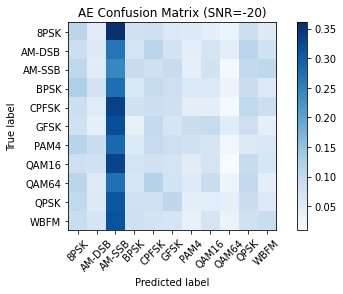

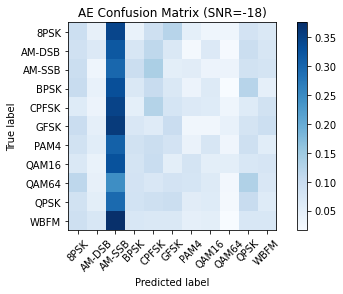

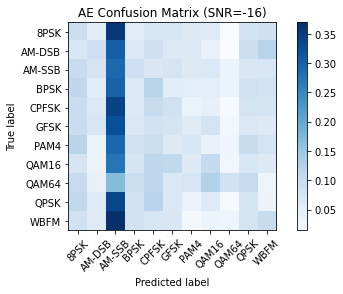

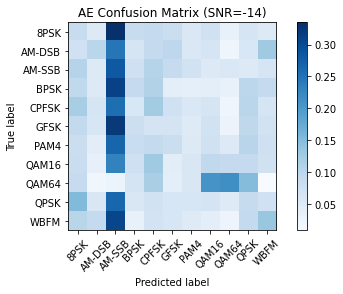

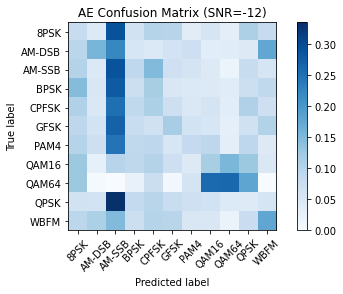

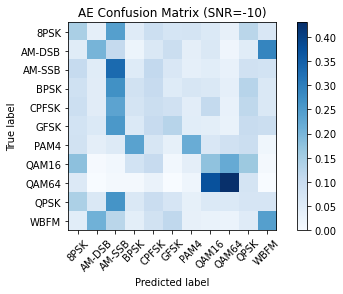

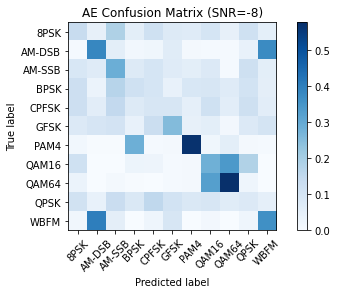

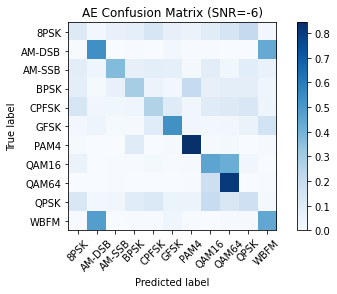

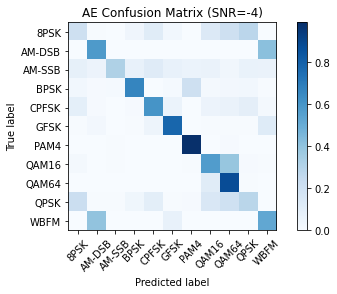

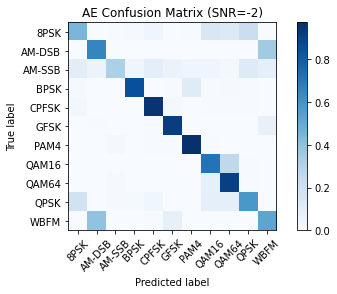

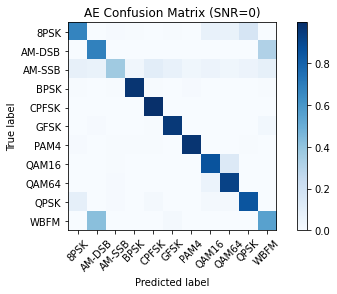

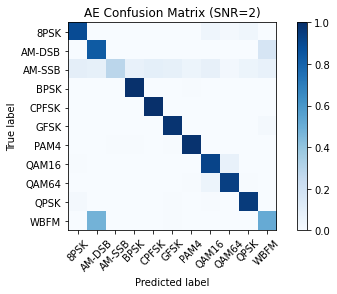

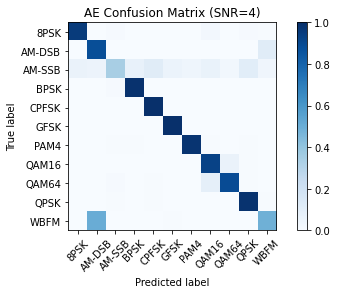

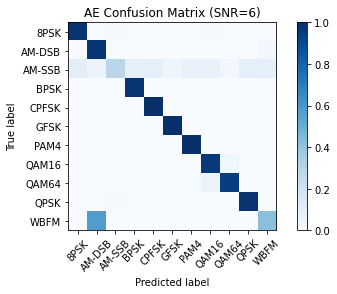

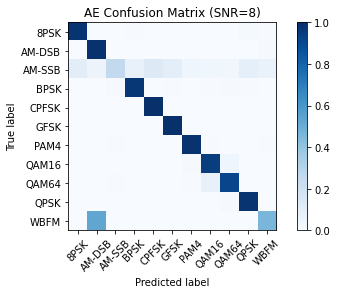

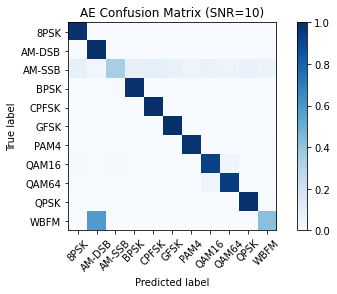

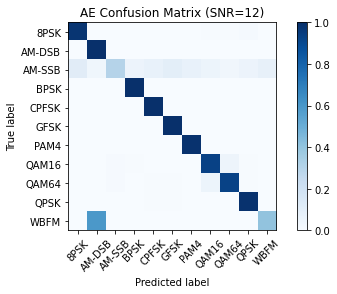

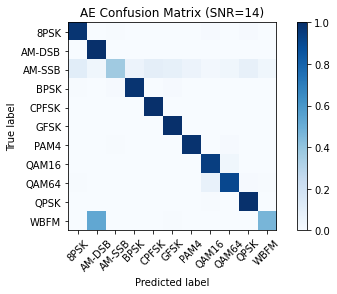

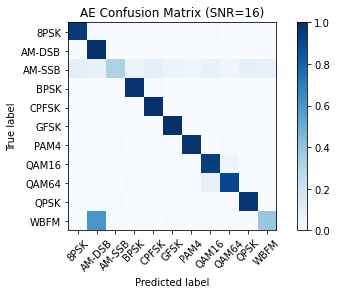

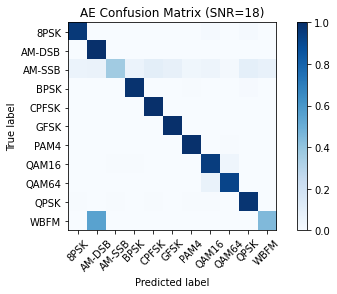

In [ ]:
# Plot confusion matrix
acc = {}
for snr_value in snrs:

    # extract classes @ SNR
    test_X_i = X_test[np.where(Y_test[:,1]==snr_value)]
    test_Y_i = Y_test[np.where(Y_test[:,1]==snr_value),0][0]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)[1]
    conf = np.zeros([modulation_num,modulation_num])
    confnorm = np.zeros([modulation_num,modulation_num])
    for i in range(0,test_X_i.shape[0]):
        j = test_Y_i[i]
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,modulation_num):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=modulation_index.keys(), title="AE Confusion Matrix (SNR=%d)"%(int(snr_value)))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr_value] = 1.0*cor/(cor+ncor)

Text(0.5, 1.0, 'AE Classification Accuracy')

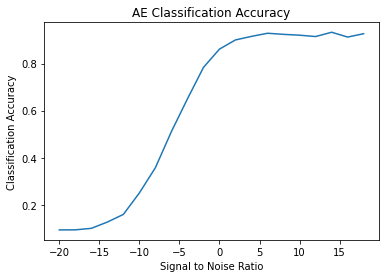

In [ ]:
acc_ = [test_accuracy[snr_value][0]/test_accuracy[snr_value][1] for snr_value in snrs]

# Plot accuracy curve
plt.plot(snrs, acc_)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("AE Classification Accuracy")
plt.grid()